In [1]:
import psycopg2
import random
import json
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.decomposition import SparsePCA,PCA
from sklearn.cluster import KMeans
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score,precision_score,recall_score



import umap.umap_ as umap


In [2]:
def getdata(query):
    with open('config.json', 'r') as f:
        config_dict = json.load(f)

    #print(config_dict)
    #print(config_dict['password'])
    record = 0
    #string = "user=config_dict['user'] password = config_dict['password'] host = config_dict['host'] dbname = config_dict['dbname'] port = config_dict['port']"
    try:
        connection = psycopg2.connect(user=config_dict['user'],
                                      password=config_dict['password'],
                                      host=config_dict['host'],
                                      dbname=config_dict['dbname'],
                                      port=config_dict['port'])

        cursor = connection.cursor()
        # Print PostgreSQL Connection properties
        print ( connection.get_dsn_parameters(),"\n")

        # Print PostgreSQL version
        #cursor.execute("SELECT version();")
        cursor.execute(query)
        record = cursor.fetchall()
        #print("You are connected to - ", record,"\n")

    except (Exception, psycopg2.Error) as error :
        print ("Error while connecting to PostgreSQL", error)
    finally:
        #closing database connection.
            if(connection):
                cursor.close()
                connection.close()
                print("PostgreSQL connection is closed")
    return record;

PCA plots

{'user': 'mlcalss', 'dbname': 'nydn', 'host': 'dbt-dpl-dev.c913t1mfbggj.us-east-1.redshift.amazonaws.com', 'port': '5439', 'tty': '', 'options': '', 'sslmode': 'prefer', 'sslcompression': '0', 'krbsrvname': 'postgres', 'target_session_attrs': 'any'} 

PostgreSQL connection is closed
hihi 931 931
hi [list([3408, 18, 0, 241, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]) 1]
xtrain [[3408, 18, 0, 241, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [7596, 15, 0, 3, 0, 0, 5, 0, 0, 248, 0, 0, 0, 1, 0, 0, 0, 0, 0], [11023, 36, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [10235, 64, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [324, 42, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
3
eigenvalues (array([3.23931947+0.00000000e+00j, 0.53314648+0.00000000e+00j,
       1.33717647+0.00000000e+00j, 1.90122064+0.00000000e+00j,
       0.53314648+0.00000000e+00j, 0.53314648+0.00000000e+00j,
       0.53314648+0.00000000e+00j, 0.53314648+0.00000000e+00j,
       0.53314648+0.00000000e+0

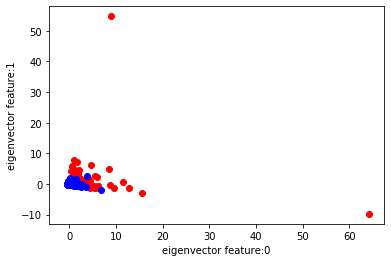

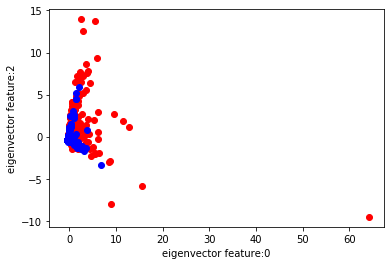

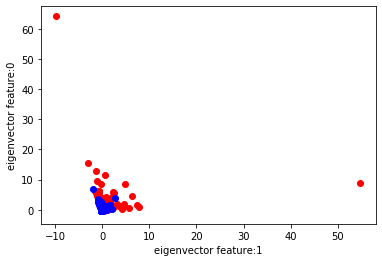

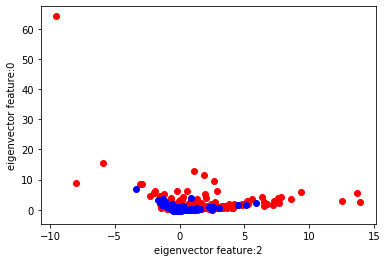

In [3]:
#total_engaged_time, days_since_user_signup
query = ("SELECT total_engaged_time, months_since_user_signup, total_overview_views,"
         "total_search_views,total_export_actions,total_report_actions,"
         "total_detail_views,total_overlay_views,total_info_views,"
         "total_referrer_views,"
         "total_author_views,total_section_views,total_tag_views,total_page_type_views,total_settings_views,"
         "total_campaign_group_actions,total_campaign_views,total_share_page_actions,"
         "total_token_actions,"
         "did_return_visit FROM visitors_by_month LIMIT 12000;") # ORDER BY RANDOM()
 # need better query

data = getdata(query)
data = [[data if data is not None else 0 for data in x_i] for x_i in data]
data = [(x_i[0:len(x_i)-1],x_i[-1]) for x_i in data]

# train,valid, test split
train = data[0:9999]
valid = data[10000:10999]
test = data[11000:11999]


# subsample from training to fix inbalance
red = np.array([x_i for x_i in train if x_i[-1] ==1])
blue = np.array([x_i for x_i in train if x_i[-1] ==0])
num = min(len(red),len(blue))

newred = red[0:num]
newblue = blue[0:num]

print("hihi",len(newred),len(newblue))
train = np.concatenate((newred,newblue))
print("hi",train[0])

# split 

X_train = [x_i[0] for x_i in train]
y_train = [x_i[1] for x_i in train]
X_valid = [x_i[0] for x_i in valid]
y_valid = [x_i[1] for x_i in valid]

print('xtrain',X_train[0:5])
# don't touch the test set until final report!!!!!!!!
#X_test = [i[0] for i in test]
#y_test = [i[1] for i in test]



# # train pca
X_train = StandardScaler().fit_transform(X_train)
X_valid = StandardScaler().fit_transform(X_valid)
#pca = SparsePCA(n_components=6)
pca = PCA(3)
pca.fit(X_train) 

print(pca.n_components_ )
print('eigenvalues',np.linalg.eig(pca.get_covariance()))


# transform data
X_train = pca.transform(X_train)
X_valid = pca.transform(X_valid)

print(X_train[0],y_train[0])

red = np.array([x for x,y in zip(X_train,y_train) if y ==1])
blue = np.array([x for x,y in zip(X_train,y_train) if y ==0])

for i in range(pca.n_components_):
    for j in range(pca.n_components_ - i):
        if(i!= j):
            plt.scatter(red[:,i],red[:,j],color = 'red')
            plt.scatter(blue[:,i],blue[:,j], color = 'blue')
            plt.xlabel("eigenvector feature:"+str(i))
            plt.ylabel("eigenvector feature:"+str(j))
            plt.show()

t-SNE plots

{'user': 'mlcalss', 'dbname': 'nydn', 'host': 'dbt-dpl-dev.c913t1mfbggj.us-east-1.redshift.amazonaws.com', 'port': '5439', 'tty': '', 'options': '', 'sslmode': 'prefer', 'sslcompression': '0', 'krbsrvname': 'postgres', 'target_session_attrs': 'any'} 

PostgreSQL connection is closed
0
1
2
3
4
5
6
7
8
9
10
11


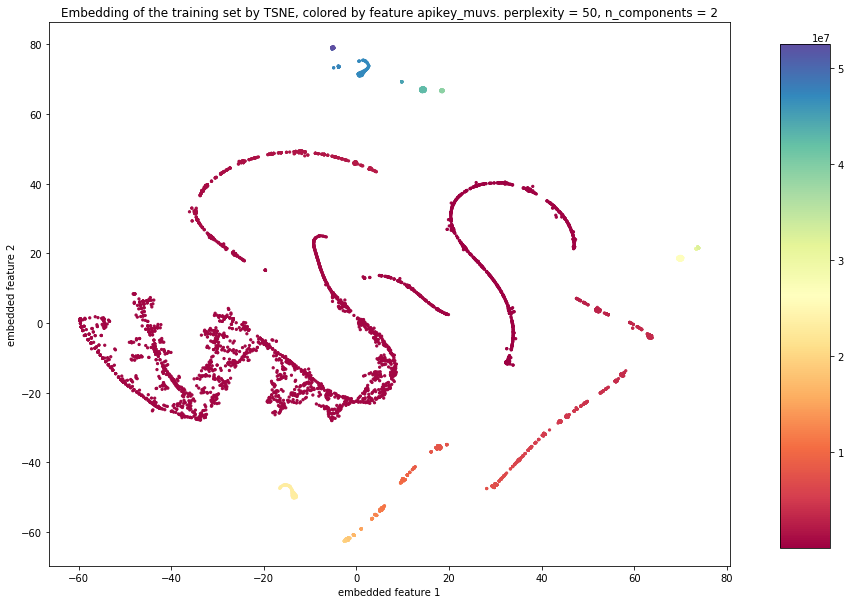

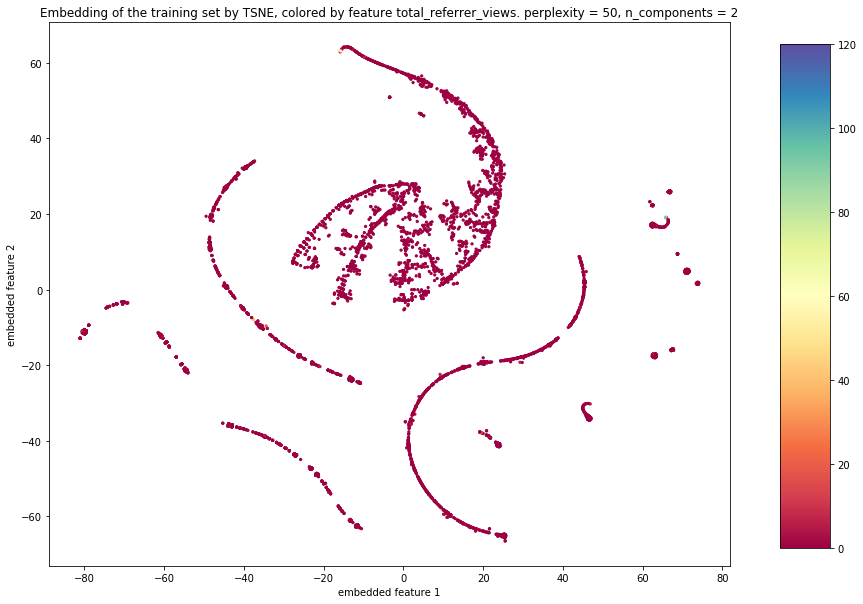

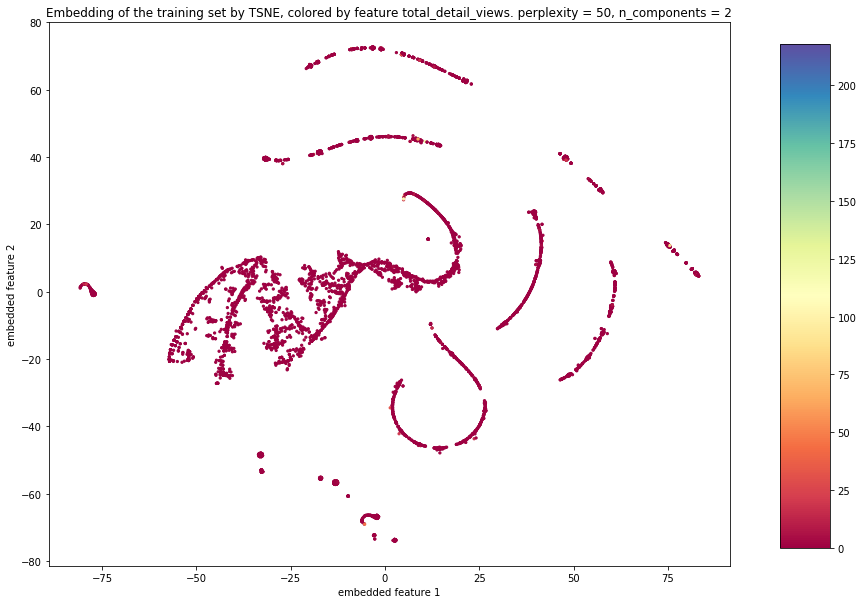

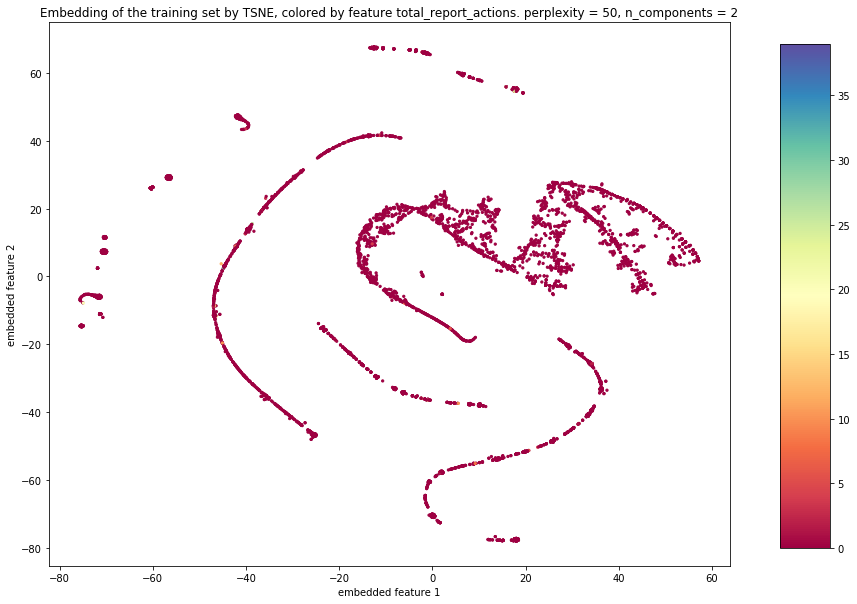

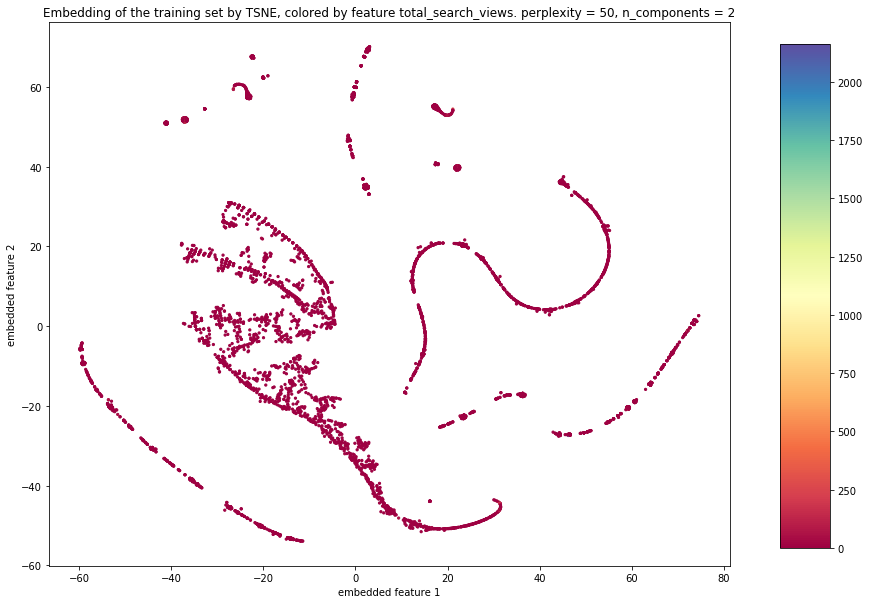

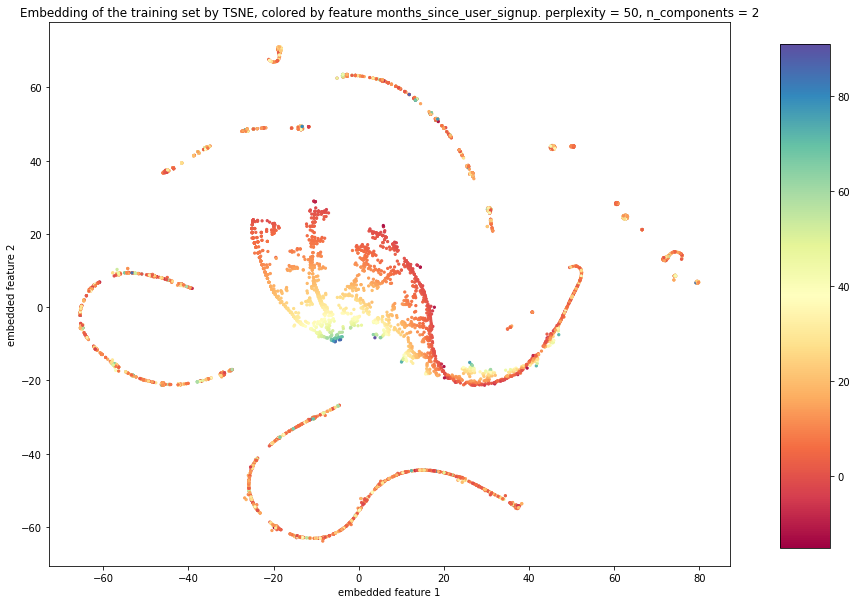

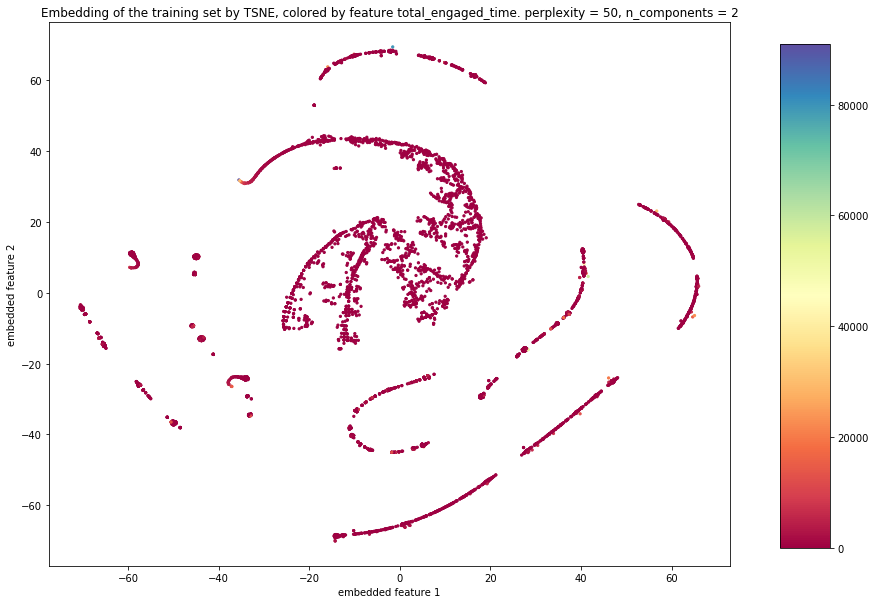

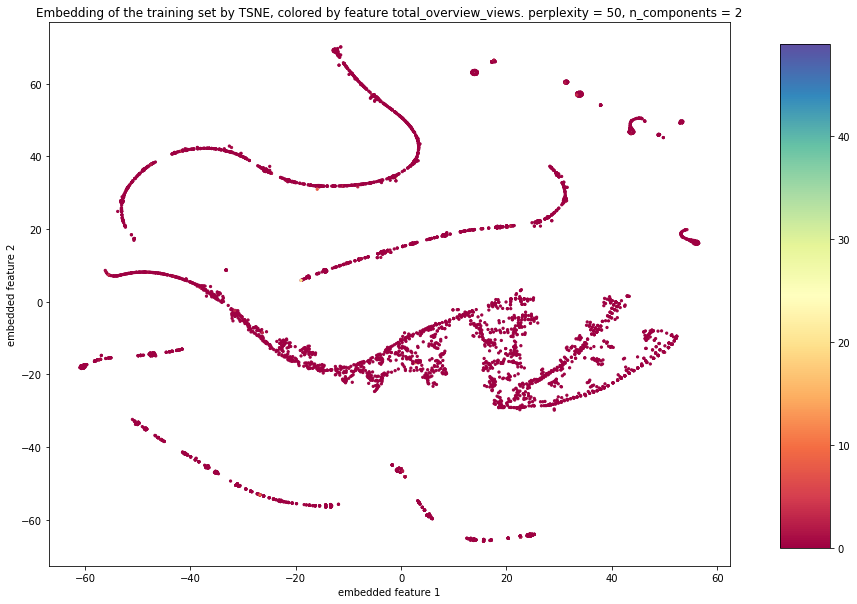

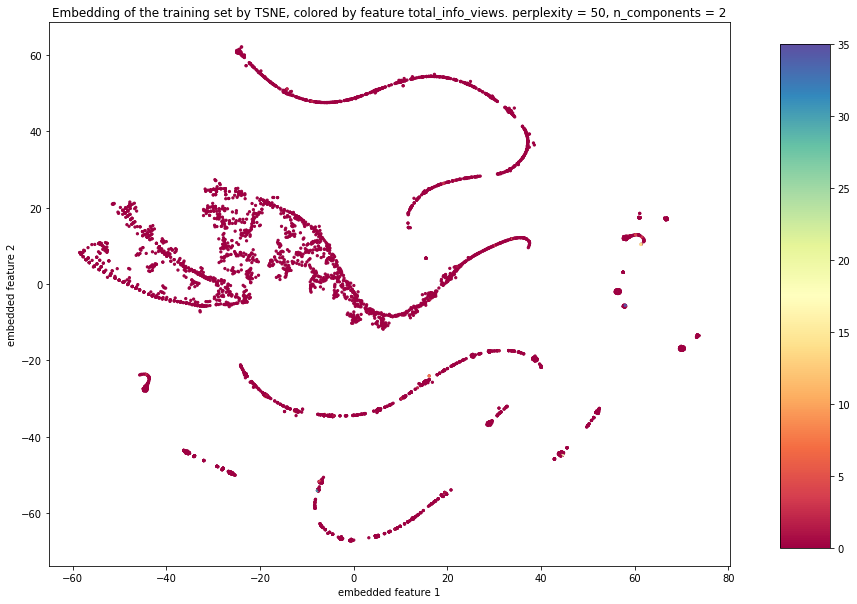

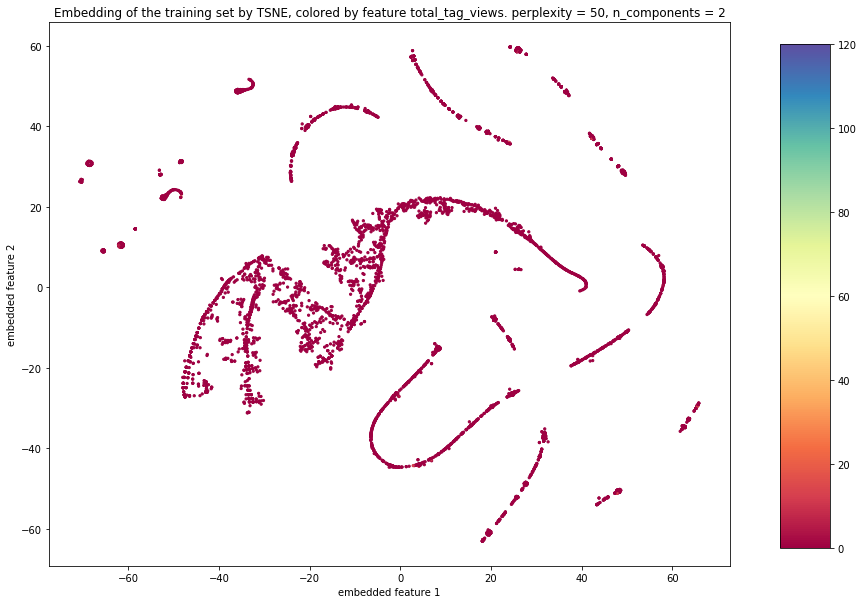

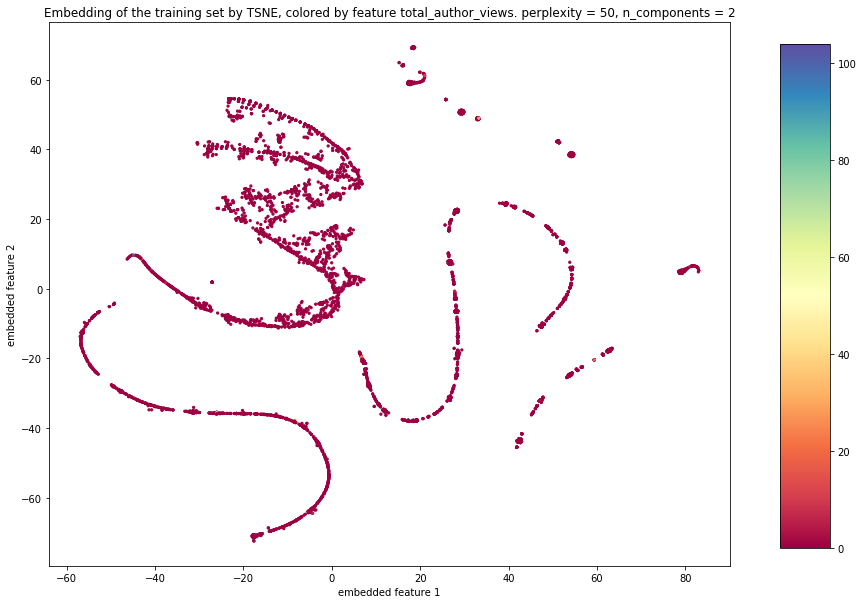

In [ ]:
from sklearn.manifold import TSNE
query = '''(SELECT TOP 3000
apikey_muvs,
total_referrer_views,
total_detail_views,
total_report_actions,
total_search_views,
months_since_user_signup,
total_engaged_time,
total_overview_views,
total_info_views,
total_tag_views,
total_author_views,
total_section_views,
did_return_visit 
   FROM visitors_by_month
   where did_return_visit = 0 
   ORDER BY RANDOM())
UNION ALL
(SELECT TOP 3000
apikey_muvs,
total_referrer_views,
total_detail_views,
total_report_actions,
total_search_views,
months_since_user_signup,
total_engaged_time,
total_overview_views,
total_info_views,
total_tag_views,
total_author_views,
total_section_views,
did_return_visit 
   FROM visitors_by_month
   where did_return_visit = 1 
   ORDER BY RANDOM());'''

feature_list = [
    "apikey_muvs",
    "total_referrer_views",
    "total_detail_views",
    "total_report_actions",
    "total_search_views",
    "months_since_user_signup",
    "total_engaged_time",
    "total_overview_views",
    "total_info_views",
    "total_tag_views",
    "total_author_views",
    "total_section_views",
]

data = getdata(query)
data = [[data if data is not None else 0 for data in x_i] for x_i in data]
data = [(x_i[0:len(x_i)-1],x_i[-1]) for x_i in data] 

X = [x_i[0] for x_i in data]
y = [x_i[1] for x_i in data]

# train,valid, test split



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=1)

# X_train = StandardScaler(X_train)
# X_valid = StandardScaler(X_valid)


features = [
        'apikey_muvs',
        'total_referrer_views',
        'total_detail_views',
        'total_report_actions',
        'total_search_views',
        'months_since_user_signup', 
        'total_engaged_time', 
        'total_overview_views',
        'total_info_views',
        'total_tag_views',
        'total_author_views',
        'total_section_views'
        ]
feature_ids = range(len(features))
dim = 2
perplexity = 50
X_train_transformed = list(zip(*X_train))
for i in range(len(X_train_transformed)):
    print(i)
    fig, ax = plt.subplots(1,1, figsize=(14, 10))
    trans = TSNE(n_components=dim,perplexity = perplexity).fit(X = X_train, y = y_train);
    classes = sorted(list(set(X_train_transformed[i])))
    plot1=ax.scatter(trans.embedding_[:, 0], trans.embedding_[:, 1], s = 5, c = X_train_transformed[i], cmap = 'Spectral')
    #plot2=ax[1].scatter(trans.embedding_[:, 1], trans.embedding_[:, 2], s = 5, c = X_train_transformed[i], cmap = 'Spectral')
    #plt.setp(ax, xticks=[], yticks=[])
    #for aax in ax.flat:
    #    im = aax.imshow()
    #cbar = fig.colorbar()
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    #fig.colorbar(im, cax=cbar_ax)
    #cb_ax = fig.add_axes([0.83, 0.1, 0.02, 0.8])
    plt.colorbar(plot1,cax=cbar_ax)
    
    # cbar.set_ticks(np.arange(10))
    #cbar_ax.set_ticklabels(classes)
    ax.set_xlabel('embedded feature 1')
    ax.set_ylabel('embedded feature 2')
    #ax[1].set_xlabel('embedded feature 2')
    #ax[1].set_ylabel('embedded feature 3')
    ax.set_title('Embedding of the training set by TSNE, colored by feature {}. perplexity = {}, n_components = {}'.format(feature_list[i],perplexity,dim),
                  fontsize=12)
    plt.plot()


umap plots

{'user': 'mlcalss', 'dbname': 'nydn', 'host': 'dbt-dpl-dev.c913t1mfbggj.us-east-1.redshift.amazonaws.com', 'port': '5439', 'tty': '', 'options': '', 'sslmode': 'prefer', 'sslcompression': '0', 'krbsrvname': 'postgres', 'target_session_attrs': 'any'} 

PostgreSQL connection is closed
0


/home/dima/anaconda3/lib/python3.7/site-packages/numba/compiler.py:588: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../anaconda3/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))
/home/dima/anaconda3/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 83 separate connected components using meta-embedding (experimental)
  n_components
/home/dima/anaconda3/lib/python3.7/site-packages/sklearn/manifold/spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


1


/home/dima/anaconda3/lib/python3.7/site-packages/numba/compiler.py:588: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../anaconda3/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))
/home/dima/anaconda3/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 83 separate connected components using meta-embedding (experimental)
  n_components
/home/dima/anaconda3/lib/python3.7/site-packages/sklearn/manifold/spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


2


/home/dima/anaconda3/lib/python3.7/site-packages/numba/compiler.py:588: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../anaconda3/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))
/home/dima/anaconda3/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 83 separate connected components using meta-embedding (experimental)
  n_components
/home/dima/anaconda3/lib/python3.7/site-packages/sklearn/manifold/spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


3


/home/dima/anaconda3/lib/python3.7/site-packages/numba/compiler.py:588: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../anaconda3/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))
/home/dima/anaconda3/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 83 separate connected components using meta-embedding (experimental)
  n_components
/home/dima/anaconda3/lib/python3.7/site-packages/sklearn/manifold/spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


4


/home/dima/anaconda3/lib/python3.7/site-packages/numba/compiler.py:588: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../anaconda3/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))
/home/dima/anaconda3/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 84 separate connected components using meta-embedding (experimental)
  n_components
/home/dima/anaconda3/lib/python3.7/site-packages/sklearn/manifold/spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


5


/home/dima/anaconda3/lib/python3.7/site-packages/numba/compiler.py:588: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../anaconda3/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))
/home/dima/anaconda3/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 83 separate connected components using meta-embedding (experimental)
  n_components
/home/dima/anaconda3/lib/python3.7/site-packages/sklearn/manifold/spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


6


/home/dima/anaconda3/lib/python3.7/site-packages/numba/compiler.py:588: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../anaconda3/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))
/home/dima/anaconda3/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 83 separate connected components using meta-embedding (experimental)
  n_components
/home/dima/anaconda3/lib/python3.7/site-packages/sklearn/manifold/spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


7


/home/dima/anaconda3/lib/python3.7/site-packages/numba/compiler.py:588: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../anaconda3/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))
/home/dima/anaconda3/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 83 separate connected components using meta-embedding (experimental)
  n_components
/home/dima/anaconda3/lib/python3.7/site-packages/sklearn/manifold/spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


8


/home/dima/anaconda3/lib/python3.7/site-packages/numba/compiler.py:588: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../anaconda3/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))
/home/dima/anaconda3/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 83 separate connected components using meta-embedding (experimental)
  n_components
/home/dima/anaconda3/lib/python3.7/site-packages/sklearn/manifold/spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


9


/home/dima/anaconda3/lib/python3.7/site-packages/numba/compiler.py:588: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../anaconda3/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))
/home/dima/anaconda3/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 83 separate connected components using meta-embedding (experimental)
  n_components
/home/dima/anaconda3/lib/python3.7/site-packages/sklearn/manifold/spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


10


/home/dima/anaconda3/lib/python3.7/site-packages/numba/compiler.py:588: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../anaconda3/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))
/home/dima/anaconda3/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 84 separate connected components using meta-embedding (experimental)
  n_components
/home/dima/anaconda3/lib/python3.7/site-packages/sklearn/manifold/spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


11


/home/dima/anaconda3/lib/python3.7/site-packages/numba/compiler.py:588: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../anaconda3/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))
/home/dima/anaconda3/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 83 separate connected components using meta-embedding (experimental)
  n_components
/home/dima/anaconda3/lib/python3.7/site-packages/sklearn/manifold/spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


12


/home/dima/anaconda3/lib/python3.7/site-packages/numba/compiler.py:588: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../anaconda3/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))
/home/dima/anaconda3/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 83 separate connected components using meta-embedding (experimental)
  n_components
/home/dima/anaconda3/lib/python3.7/site-packages/sklearn/manifold/spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


13


/home/dima/anaconda3/lib/python3.7/site-packages/numba/compiler.py:588: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../anaconda3/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))
/home/dima/anaconda3/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 84 separate connected components using meta-embedding (experimental)
  n_components
/home/dima/anaconda3/lib/python3.7/site-packages/sklearn/manifold/spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


IndexError: list index out of range

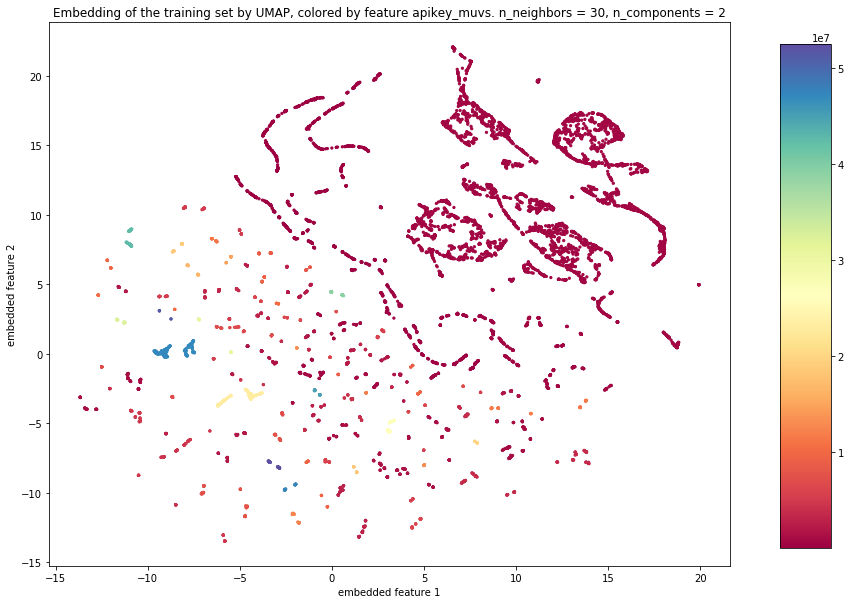

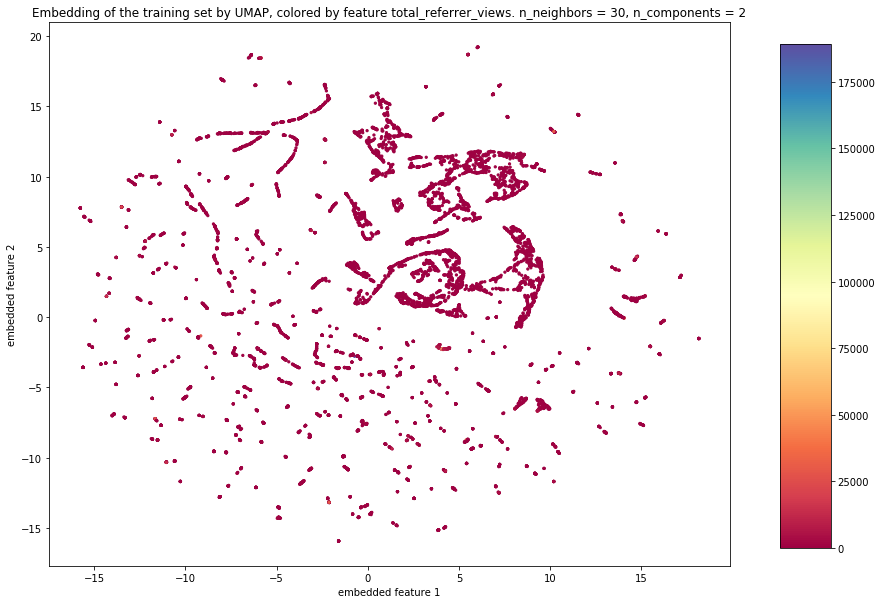

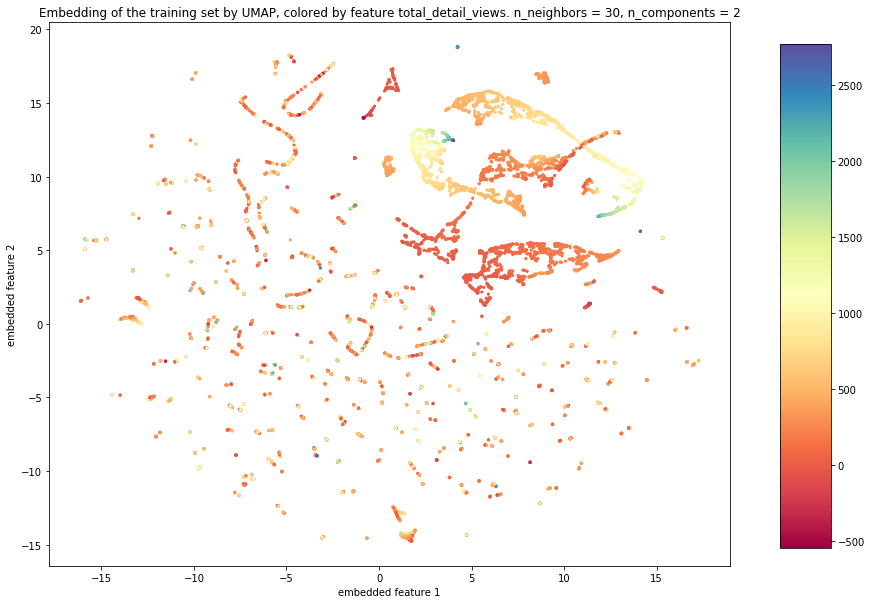

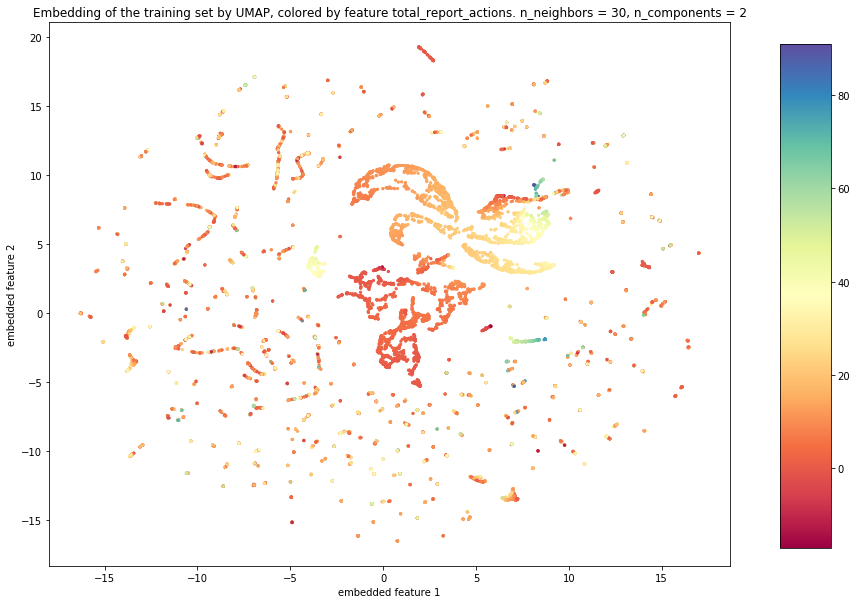

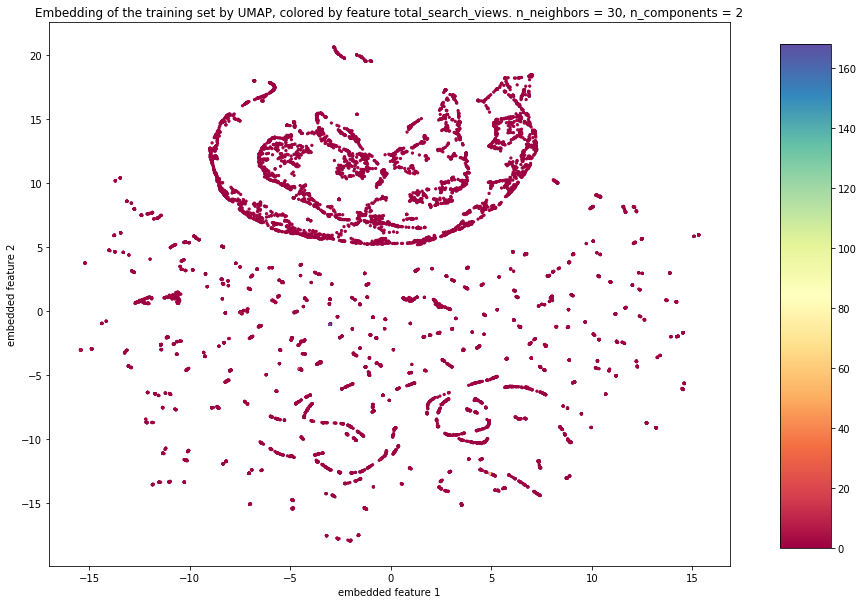

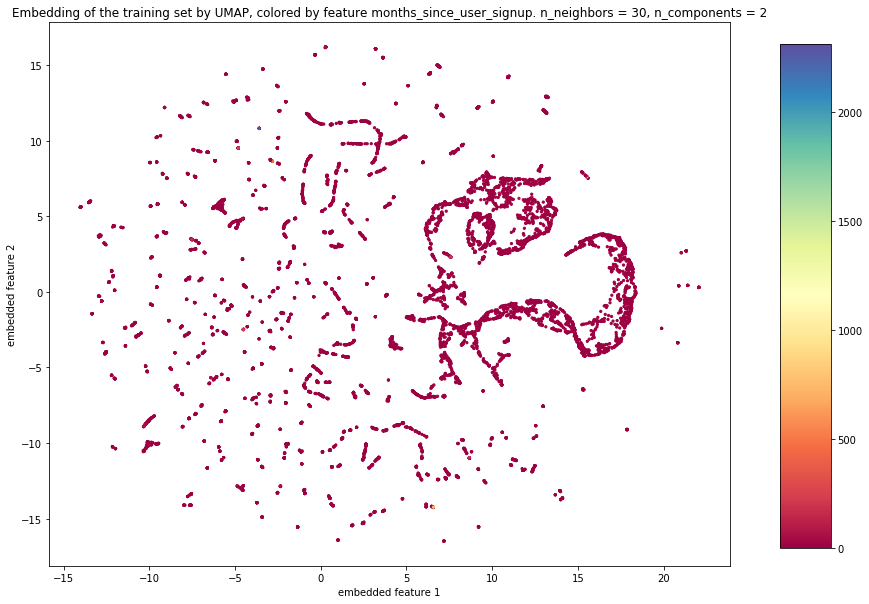

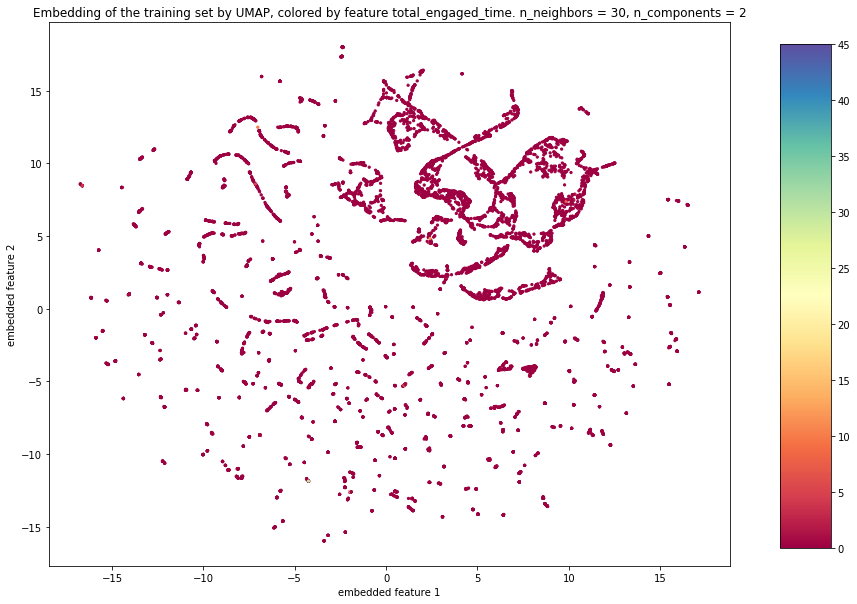

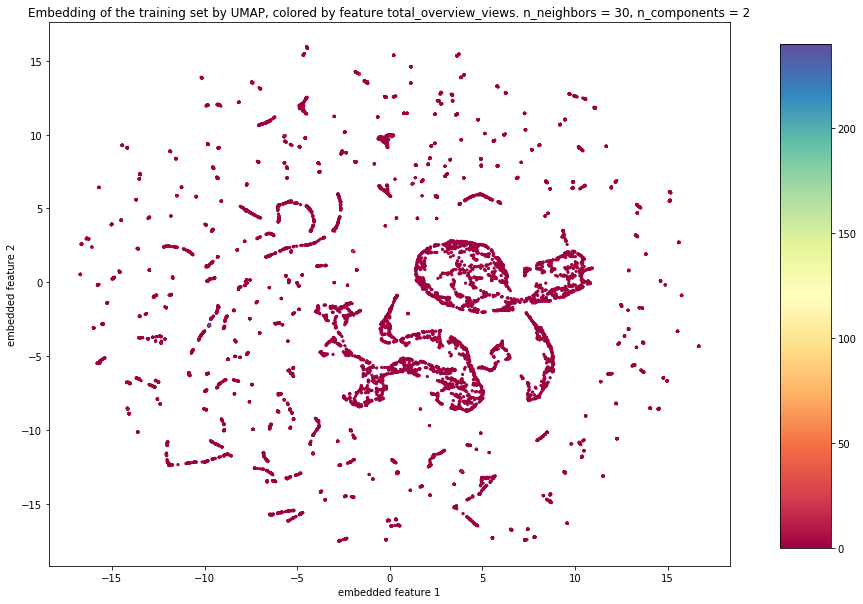

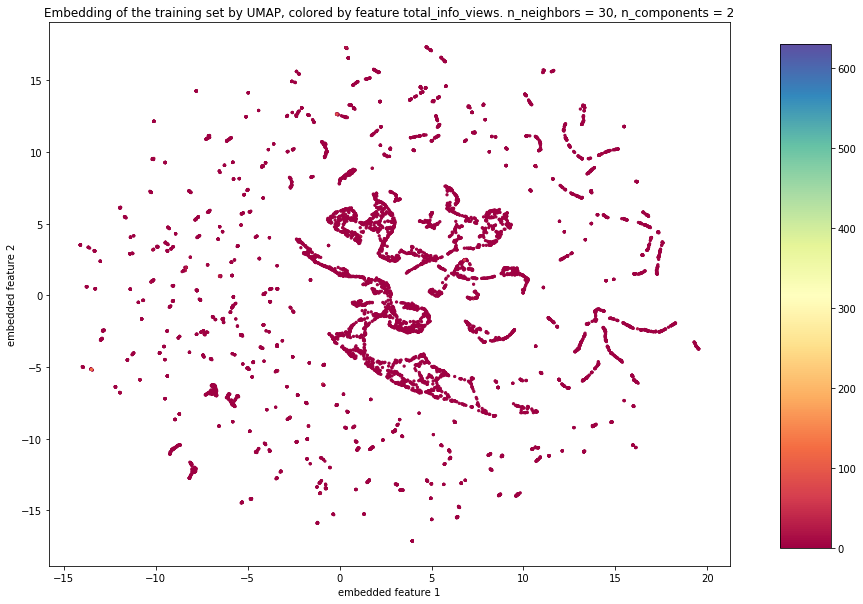

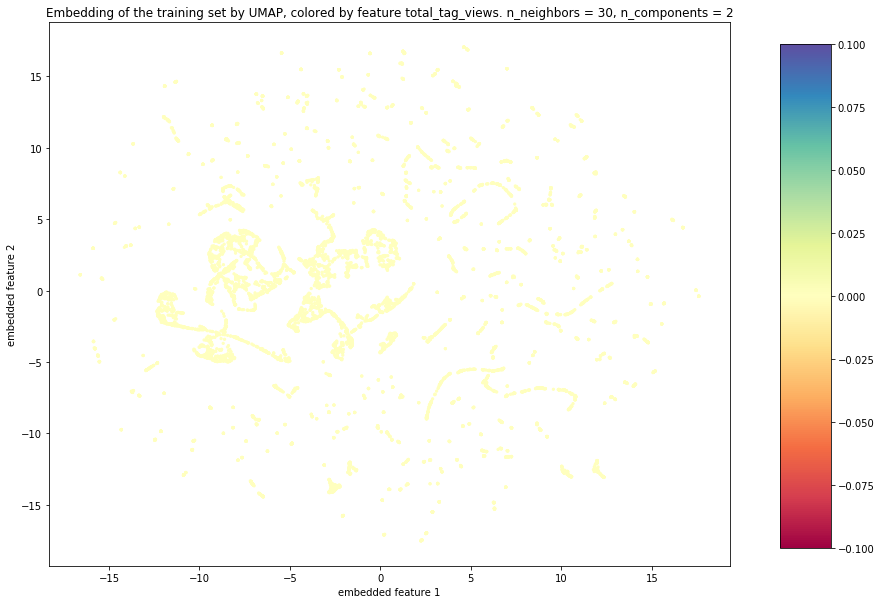

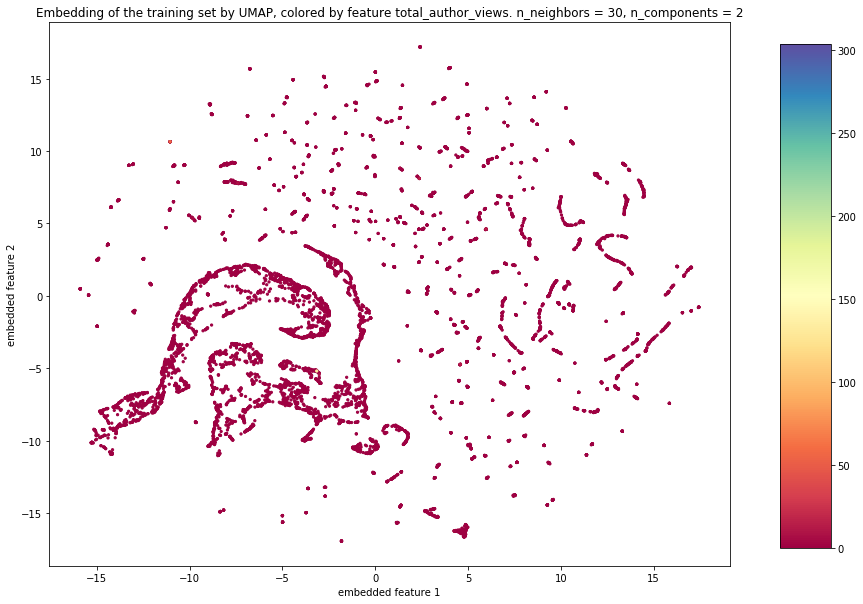

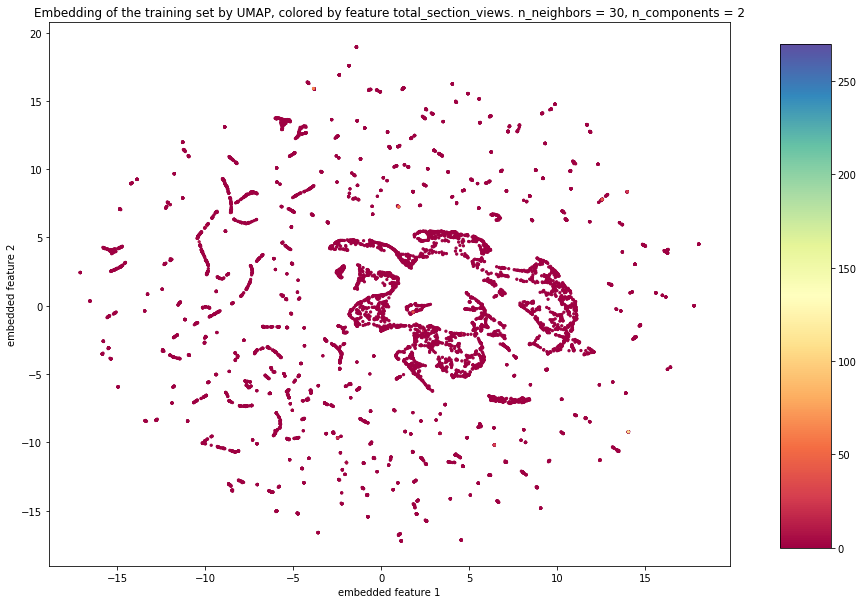

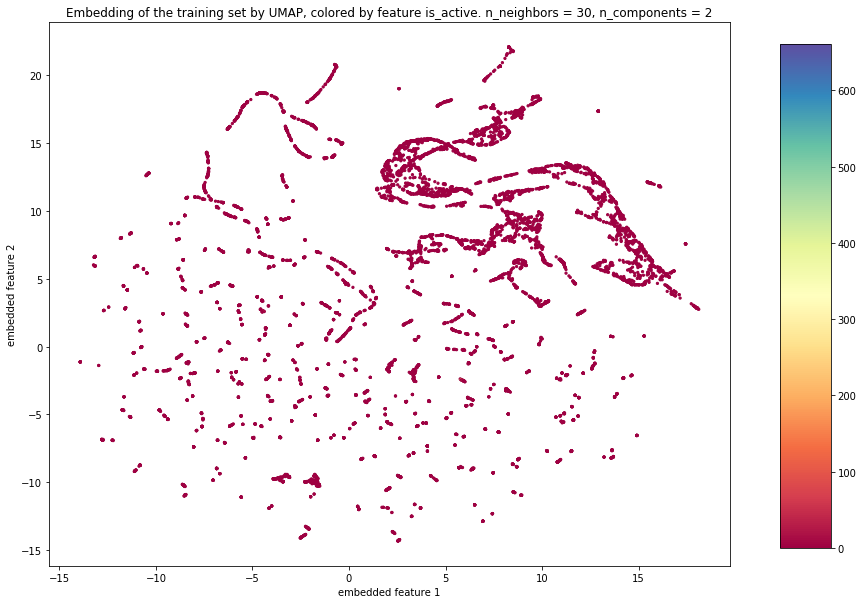

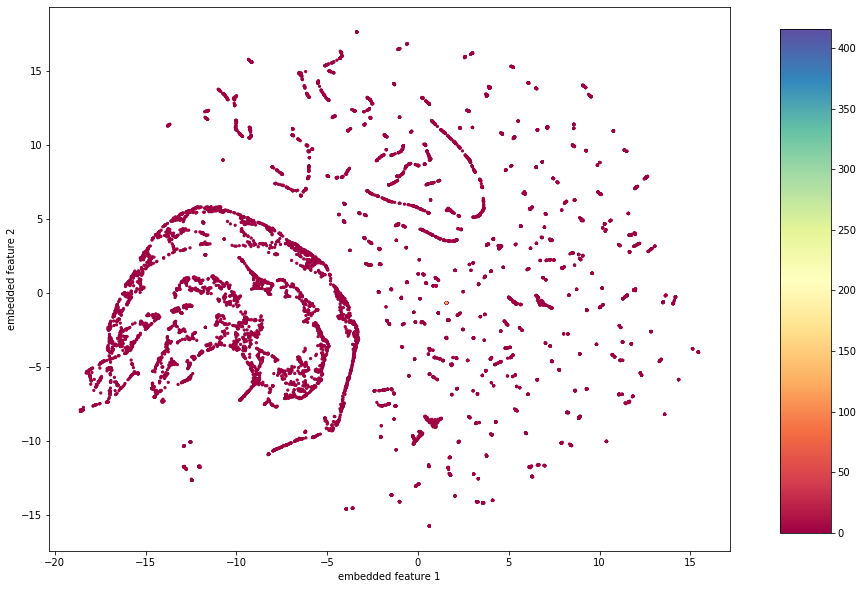

In [23]:
query_umap_totals = '''(SELECT TOP 6000
apikey_muvs,
total_engaged_time, days_since_user_signup, months_since_user_signup, 
total_overview_views, total_search_views, 
total_export_actions, total_report_actions, 
total_detail_views, total_overlay_views, 
total_info_views, total_referrer_views,
total_author_views, total_section_views,  
total_tag_views, total_page_type_views,  
total_settings_views, total_campaign_group_actions, total_campaign_views,  
total_share_page_actions,  total_token_actions, did_return_visit 
   FROM visitors_by_month
   where did_return_visit = 0 
   ORDER BY RANDOM())
UNION ALL
(SELECT TOP 6000
apikey_muvs,
total_engaged_time, days_since_user_signup, months_since_user_signup, 
total_overview_views, total_search_views, 
total_export_actions, total_report_actions, 
total_detail_views, total_overlay_views, 
total_info_views, total_referrer_views,
total_author_views, total_section_views,  
total_tag_views, total_page_type_views,  
total_settings_views, total_campaign_group_actions, total_campaign_views,  
total_share_page_actions,  total_token_actions, did_return_visit
   FROM visitors_by_month
   where did_return_visit = 1 
   ORDER BY RANDOM());'''
data_umap_totals = getdata(query_umap_totals)
data_umap_totals = np.array([[data if data is not None else 0 for data in x_i] for x_i in data_umap_totals])
X_totals = np.array([x_i[0:len(x_i)-1] for x_i in data_umap_totals])
y_totals = np.array([x_i[-1] for x_i in data_umap_totals])


X_train, X_test, y_train, y_test = train_test_split(X_totals, y_totals, test_size = 0.1, random_state = 629)
X_train, X_valid, y_train, y_valid = train_test_split(X_totals, y_totals, test_size = 0.1, random_state = 629)

feature_list = [
    "apikey_muvs",
    "total_referrer_views",
    "total_detail_views",
    "total_report_actions",
    "total_search_views",
    "months_since_user_signup",
    "total_engaged_time",
    "total_overview_views",
    "total_info_views",
    "total_tag_views",
    "total_author_views",
    "total_section_views",
    "is_active"
]

    
X_train_transformed = list(zip(*X_train))
for i in range(len(X_train_transformed)):
    print(i)
    
    fig, ax = plt.subplots(1,1, figsize=(14, 10))
    trans = umap.UMAP(n_neighbors = 30, n_components = 2).fit(X = X_train, y = y_train);
    classes = sorted(list(set(X_train_transformed[i])))
    plot1=ax.scatter(trans.embedding_[:, 0], trans.embedding_[:, 1], s = 5, c = X_train_transformed[i], cmap = 'Spectral')
    #plot2=ax[1].scatter(trans.embedding_[:, 1], trans.embedding_[:, 2], s = 5, c = X_train_transformed[i], cmap = 'Spectral')
    #plot3=ax[2].scatter(trans.embedding_[:, 0], trans.embedding_[:, 2], s = 5, c = X_train_transformed[i], cmap = 'Spectral')
    #plt.setp(ax, xticks=[], yticks=[])
    #for aax in ax.flat:
    #    im = aax.imshow()
    #cbar = fig.colorbar()
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    #fig.colorbar(im, cax=cbar_ax)
    #cb_ax = fig.add_axes([0.83, 0.1, 0.02, 0.8])
    plt.colorbar(plot1,cax=cbar_ax)
    
    # cbar.set_ticks(np.arange(10))
    #cbar_ax.set_ticklabels(classes)
    ax.set_xlabel('embedded feature 1')
    ax.set_ylabel('embedded feature 2')
    #ax[1].set_xlabel('embedded feature 2')
    #ax[1].set_ylabel('embedded feature 3')
    #ax[2].set_xlabel('embedded feature 1')
    #ax[2].set_ylabel('embedded feature 3')
    ax.set_title('Embedding of the training set by UMAP, colored by feature {}. n_neighbors = {}, n_components = {}'.format(feature_list[i],trans.n_neighbors, trans.n_components),
                  fontsize=12)
    plt.plot()